In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [114]:
import os
import math
import time 
import json
import torch
import random
import numpy as np
import pandas as pd
from datetime import datetime
from torch.utils.data import DataLoader

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import concatenate
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

In [115]:
cd drive/MyDrive/Neuronske/doc/WikiQACorpus/


[Errno 2] No such file or directory: 'drive/MyDrive/Neuronske/doc/WikiQACorpus/'
/content/drive/MyDrive/Neuronske/doc/WikiQACorpus


# Read data

In [116]:
DATASET_FOLDER_PATH = ' WikiQACorpus/'

train_dataset_path = "WikiQA-train.tsv"
dev_dataset_path = "WikiQA-dev.tsv"

df_train = pd.read_csv(train_dataset_path, delimiter='\t')
df_dev = pd.read_csv(dev_dataset_path, delimiter='\t')

# Hyper parameters

In [117]:
epochs = 7
max_length = 40
vocab_size = 25594
embedding_dim = 100
batch_size = 32

trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

word_embeddings = None
word_embeddings_trainable=True

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
callbacks = [ModelCheckpoint("question_answer_weights.h5", monitor='val_loss', save_best_only=True)]

class_weight = {0: 1., 1: 8.}

In [118]:
df_train.head()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
0,Q1,how are glacier caves formed?,D1,Glacier cave,D1-0,A partly submerged glacier cave on Perito More...,0
1,Q1,how are glacier caves formed?,D1,Glacier cave,D1-1,The ice facade is approximately 60 m high,0
2,Q1,how are glacier caves formed?,D1,Glacier cave,D1-2,Ice formations in the Titlis glacier cave,0
3,Q1,how are glacier caves formed?,D1,Glacier cave,D1-3,A glacier cave is a cave formed within the ice...,1
4,Q1,how are glacier caves formed?,D1,Glacier cave,D1-4,"Glacier caves are often called ice caves , but...",0


In [119]:
def parse_data(df: pd.DataFrame) -> tuple:
    questions = df['Question'].tolist()
    answers = df['Sentence'].tolist()
    labels = df['Label'].tolist()
    return questions, answers, labels

Dataset 

In [120]:
questions_train, answers_train, labels_train = parse_data(df_train)
questions_dev, answers_dev, labels_dev = parse_data(df_dev)

y_train = np.array(df_train['Label'])
y_dev = np.array(df_dev['Label'])

y_train_predict = df_train['Label'].values
y_dev_predict = df_dev['Label'].values

# Lematization

In [121]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#ps = LancasterStemmer()
# ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def remove_stopwords(data):
    output_array=[]
    for sentence in data:
        temp_list=[]
        for word in sentence.split():
            if word.lower() not in stop_words:
                temp_list.append(word)
        output_array.append(' '.join(temp_list))
    return output_array

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    # words = [w for w in words if not w in stop_words] #3
    words = remove_stopwords(words)
    #words = [ps.stem(w) for w in words] #4 steming acctualy gives worse results when added #4
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data preprocessing

In [122]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)   # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text)         # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df_train['Cleaned_Questions'] = df_train['Question'].apply(clean_text)
df_train['Cleaned_Answers'] = df_train['Sentence'].apply(clean_text)
df_dev['Cleaned_Questions'] = df_dev['Question'].apply(clean_text)
df_dev['Cleaned_Answers'] = df_dev['Sentence'].apply(clean_text)

In [123]:
# training
new_str_train_question = [str(x) for x in df_train['Cleaned_Questions']]
new_str_train_answer = [str(x) for x in df_train['Cleaned_Answers']]

# validation
new_str_dev_question = [str(x) for x in df_dev['Cleaned_Questions']]
new_str_dev_answer = [str(x) for x in df_dev['Cleaned_Answers']]

# training
df_train_questions = pd.DataFrame(new_str_train_question)
df_train_answers = pd.DataFrame(new_str_train_answer)

# validation
df_dev_questions = pd.DataFrame(new_str_dev_question)
df_dev_answers = pd.DataFrame(new_str_dev_answer)

train_questions = []
train_answers = []
dev_questions = []
dev_answers = []
for i in range(len(df_train_questions)):
  train_questions.append(preprocessing(df_train_questions.iloc[i]))
for i in range(len(df_train_answers)):
  train_answers.append(preprocessing(df_train_answers.iloc[i]))
for i in range(len(df_dev_questions)):
  dev_questions.append(preprocessing(df_dev_questions.iloc[i]))
for i in range(len(df_dev_answers)):
  dev_answers.append(preprocessing(df_dev_answers.iloc[i]))

# Data Frame preparation

In [124]:
# convert df to list

questions_training = train_questions
answers_training = train_answers
labels_training = df_train['Label'].values.tolist()

questions_dev = dev_questions
answers_dev = dev_answers
labels_dev = df_dev['Label'].values.tolist()

# Tokenization

In [125]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Training-questions
tokenizer.fit_on_texts(questions_training)
training_questions = tokenizer.texts_to_sequences(questions_training)
training_questions_padded = pad_sequences(training_questions, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Training-answers
tokenizer.fit_on_texts(answers_training)
training_answers = tokenizer.texts_to_sequences(answers_training)
training_answers_padded = pad_sequences(training_answers, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Validation-questions
tokenizer.fit_on_texts(questions_dev)
dev_questions = tokenizer.texts_to_sequences(questions_dev)
dev_questions_padded = pad_sequences(dev_questions, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Validation-answers
tokenizer.fit_on_texts(answers_dev)
dev_answers = tokenizer.texts_to_sequences(answers_dev)
dev_answers_padded = pad_sequences(dev_answers, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [126]:
import numpy as np
training_questions_padded = np.array(training_questions_padded)
training_answers_padded = np.array(training_answers_padded)
training_labels = np.array(labels_training)

dev_questions_padded = np.array(dev_questions_padded)
dev_answers_padded = np.array(dev_answers_padded)
dev_labels = np.array(labels_dev)

# Model construction

In [127]:
from keras.layers import Input, Dense, Embedding, LSTM, Dropout, Activation, concatenate, BatchNormalization
import tensorflow as tf

# model input
q_input = Input(shape=(max_length,))
a_input = Input(shape=(max_length,))

In [128]:
# embedding layer
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_length,
          trainable=word_embeddings_trainable)

# conversion into word embedding matrix
q = embedding_layer(q_input)
a = embedding_layer(a_input)


# add LSTM layer, get their new representation
q = LSTM(50, return_sequences=True)(q)
a = LSTM(50, return_sequences=True)(a)

q = LSTM(50, return_sequences=False)(q)
a = LSTM(50, return_sequences=False)(a)

# concatenate vectors for classification
merged = concatenate([q, a])

# add dense layer, and dropout, batch normalization to prevent over fitting
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)

# another layer
merged = Dense(200, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = BatchNormalization()(merged)

# output layer
output = Dense(2, activation='sigmoid')(merged)

In [129]:
model = Model([q_input, a_input], output)
adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [130]:
y_categorical = tf.keras.utils.to_categorical(
    labels_train, num_classes=2, dtype='float32'
)

y_categorical_dev = tf.keras.utils.to_categorical(
    labels_dev, num_classes=2, dtype='float32'
)

validation_data=([dev_questions_padded, dev_answers_padded], y_categorical_dev)

In [131]:

print("Starting training at", datetime.now())
start_time = time.time()

# start training
history = model.fit([training_questions_padded, training_answers_padded], y_categorical, epochs=epochs, batch_size=batch_size, callbacks=callbacks,
                          class_weight=class_weight,validation_data=validation_data)

end_time = time.time()
print("Training ended at", datetime.now())
print("Minutes elapsed: %f" % ((end_time - start_time) / 60.))

Starting training at 2022-07-15 12:45:22.293086
Epoch 1/7
636/636 [==============================] - 18s 19ms/step - loss: 0.9410 - val_loss: 0.3909
Epoch 2/7
636/636 [==============================] - 10s 16ms/step - loss: 0.6589 - val_loss: 0.3111
Epoch 3/7
636/636 [==============================] - 10s 16ms/step - loss: 0.4281 - val_loss: 0.5064
Epoch 4/7
636/636 [==============================] - 11s 18ms/step - loss: 0.2579 - val_loss: 0.2814
Epoch 5/7
636/636 [==============================] - 10s 16ms/step - loss: 0.1750 - val_loss: 0.3183
Epoch 6/7
636/636 [==============================] - 10s 16ms/step - loss: 0.1294 - val_loss: 0.5830
Epoch 7/7
636/636 [==============================] - 10s 16ms/step - loss: 0.1060 - val_loss: 0.6178
Training ended at 2022-07-15 12:46:49.694721
Minutes elapsed: 1.456690


In [132]:
p = model.predict([training_questions_padded, training_answers_padded])
y_pred = []
for prediction in p:
    y_pred.append(np.argmax(prediction, axis=0))

In [133]:
print(confusion_matrix(y_train_predict, y_pred))

[[18998   310]
 [    4  1035]]


In [134]:
print(classification_report(y_train_predict, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     19308
           1       0.77      1.00      0.87      1039

    accuracy                           0.98     20347
   macro avg       0.88      0.99      0.93     20347
weighted avg       0.99      0.98      0.99     20347



In [135]:
print(f1_score(y_train, y_pred, average="macro"))

0.9300461486040233


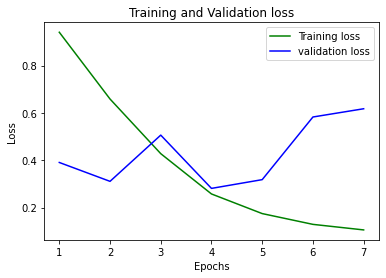

In [136]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test

In [137]:
p = model.predict([dev_questions_padded, dev_answers_padded])
y_dev_pred = []
for prediction in p:
    y_dev_pred.append(np.argmax(prediction, axis=0))

In [138]:
print(confusion_matrix(y_dev_predict, y_dev_pred))

[[2317  276]
 [ 122   18]]


In [139]:
print(classification_report(y_dev_predict, y_dev_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2593
           1       0.06      0.13      0.08       140

    accuracy                           0.85      2733
   macro avg       0.51      0.51      0.50      2733
weighted avg       0.90      0.85      0.88      2733



In [140]:
print(f1_score(y_dev_predict, y_dev_pred, average="macro"))

0.5019277545368627
